In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.shape

(440, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [7]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [8]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

# Lesson 

In [9]:
# make dataframe for cluster
lesson_df = df[["Grocery", "Milk","Fresh"]]

In [10]:
lesson_df.head()

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057
2,7684,8808,6353
3,4221,1196,13265
4,7198,5410,22615


In [11]:
lesson_df.shape

(440, 3)

In [12]:
# convert to numpy array
np_array = lesson_df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,  9656., 12669.],
       [ 9568.,  9810.,  7057.],
       [ 7684.,  8808.,  6353.],
       [ 4221.,  1196., 13265.],
       [ 7198.,  5410., 22615.],
       [ 5126.,  8259.,  9413.],
       [ 6975.,  3199., 12126.],
       [ 9426.,  4956.,  7579.],
       [ 6192.,  3648.,  5963.],
       [18881., 11093.,  6006.]], dtype=float32)

In [13]:
# scale to MinMax
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.08146416, 0.13072723, 0.11294005],
       [0.10309667, 0.13282411, 0.06289903],
       [0.08278991, 0.11918086, 0.05662161],
       [0.04546386, 0.01553586, 0.11825445],
       [0.07755155, 0.07291369, 0.20162643],
       [0.05521843, 0.11170568, 0.08390699],
       [0.07514793, 0.04280871, 0.10809823],
       [0.10156612, 0.06673203, 0.06755359],
       [0.06670834, 0.04892229, 0.05314406],
       [0.20347716, 0.15029342, 0.05352748]], dtype=float32)

In [14]:
# create model
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [15]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(lesson_df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [16]:
# Save a copy of the original dataframe
original_df = lesson_df.copy()

In [17]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [18]:
# Merge the scaled and non-scaled values into one dataframe
lesson_df = lesson_df.merge(scaled_df, on=df.index)
lesson_df = lesson_df.drop(columns=['key_0'])

In [19]:
lesson_df.head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,7561,9656,12669,0.081464,0.130727,0.112940
1,9568,9810,7057,0.103097,0.132824,0.062899
2,7684,8808,6353,0.082790,0.119181,0.056622
3,4221,1196,13265,0.045464,0.015536,0.118254
4,7198,5410,22615,0.077552,0.072914,0.201626


In [20]:
# extract labels by making predictions
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
# assign labels to a column on df
lesson_df['labels'] = labels
lesson_df.labels.value_counts()

## 409 observations belong to cluster 0

## 31 obsverations are outliers that do not belong to any cluster
### according to this model

 0    409
-1     31
Name: labels, dtype: int64

In [22]:
# view outliers
lesson_df[lesson_df.labels==-1].head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
23,22019,36423,26373,0.237300,0.495187,0.235136,-1
39,902,555,56159,0.009690,0.006808,0.500731,-1
45,21531,22044,5181,0.232040,0.299402,0.046171,-1
47,55571,54259,44466,0.598942,0.738042,0.396467,-1
49,28921,21412,4967,0.311694,0.290797,0.044263,-1


In [23]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(lesson_df.describe())
print("-------------")
print("Inliers")
print(lesson_df[lesson_df.labels==0].describe())
print("-------------")
print("Outliers")
print(lesson_df[lesson_df.labels==-1].describe())

Population
            Grocery          Milk          Fresh  Scaled_Grocery  Scaled_Milk  \
count    440.000000    440.000000     440.000000      440.000000   440.000000   
mean    7951.277273   5796.265909   12000.297727        0.085671     0.078173   
std     9503.162829   7380.377175   12647.328865        0.102430     0.100491   
min        3.000000     55.000000       3.000000        0.000000     0.000000   
25%     2153.000000   1533.000000    3127.750000        0.023174     0.020124   
50%     4755.500000   3627.000000    8504.000000        0.051225     0.048636   
75%    10655.750000   7190.250000   16933.750000        0.114821     0.097154   
max    92780.000000  73498.000000  112151.000000        1.000000     1.000000   

       Scaled_Fresh      labels  
count    440.000000  440.000000  
mean       0.106977   -0.070455  
std        0.112774    0.256203  
min        0.000000   -1.000000  
25%        0.027863    0.000000  
50%        0.075802    0.000000  
75%        0.150968  

In [24]:
## outliers appear to purchase very large quantities of grocery, milk, and fresh

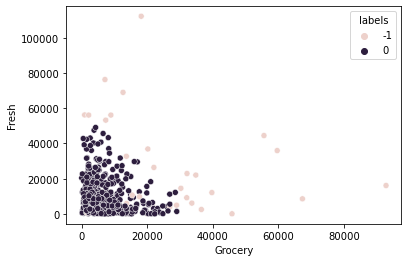

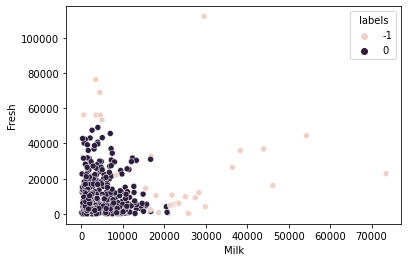

In [25]:
sns.scatterplot(lesson_df.Grocery, lesson_df.Fresh, hue=lesson_df.labels)
plt.show()

sns.scatterplot(lesson_df.Milk, lesson_df.Fresh, hue=lesson_df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

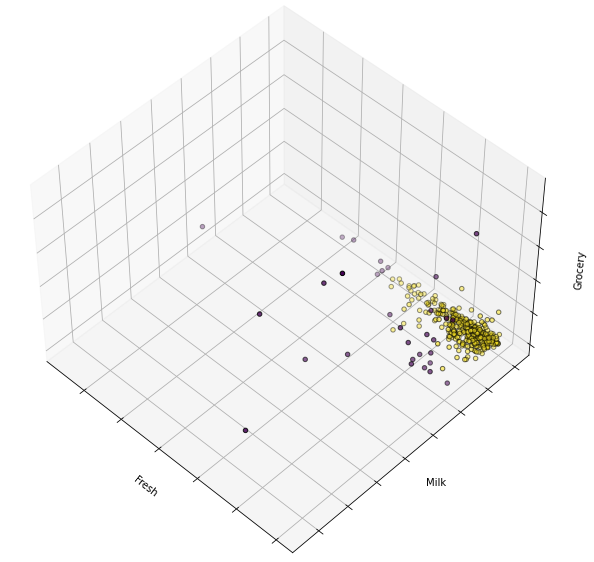

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(lesson_df.Fresh, lesson_df.Milk, lesson_df.Grocery,
           c=lesson_df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

# Experiment

## Experiment 1

### - Experiment with altering the epsilon values (the eps argument holding the threshhold parameter). Run the models and visualize the results. What has changed? Why do you think that is?



In [27]:
# make dataframe for cluster
expirement1_df = df[["Grocery", "Milk","Fresh"]]

In [28]:
expirement1_df.head()

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057
2,7684,8808,6353
3,4221,1196,13265
4,7198,5410,22615


In [29]:
# convert to numpy array
np_array = expirement1_df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,  9656., 12669.],
       [ 9568.,  9810.,  7057.],
       [ 7684.,  8808.,  6353.],
       [ 4221.,  1196., 13265.],
       [ 7198.,  5410., 22615.],
       [ 5126.,  8259.,  9413.],
       [ 6975.,  3199., 12126.],
       [ 9426.,  4956.,  7579.],
       [ 6192.,  3648.,  5963.],
       [18881., 11093.,  6006.]], dtype=float32)

In [30]:
# scale to MinMax
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.08146416, 0.13072723, 0.11294005],
       [0.10309667, 0.13282411, 0.06289903],
       [0.08278991, 0.11918086, 0.05662161],
       [0.04546386, 0.01553586, 0.11825445],
       [0.07755155, 0.07291369, 0.20162643],
       [0.05521843, 0.11170568, 0.08390699],
       [0.07514793, 0.04280871, 0.10809823],
       [0.10156612, 0.06673203, 0.06755359],
       [0.06670834, 0.04892229, 0.05314406],
       [0.20347716, 0.15029342, 0.05352748]], dtype=float32)

In [31]:
# create model

## use different epsilon 
dbsc = DBSCAN(eps = .20, min_samples = 20).fit(np_array)

In [32]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(expirement1_df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [33]:
# Save a copy of the original dataframe
original_df = expirement1_df.copy()

In [34]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [35]:
# Merge the scaled and non-scaled values into one dataframe
expirement1_df = expirement1_df.merge(scaled_df, on=expirement1_df.index)
expirement1_df = expirement1_df.drop(columns=['key_0'])

In [36]:
expirement1_df.head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,7561,9656,12669,0.081464,0.130727,0.112940
1,9568,9810,7057,0.103097,0.132824,0.062899
2,7684,8808,6353,0.082790,0.119181,0.056622
3,4221,1196,13265,0.045464,0.015536,0.118254
4,7198,5410,22615,0.077552,0.072914,0.201626


In [37]:
# extract labels by making predictions
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
# assign labels to a column on df
expirement1_df['labels'] = labels
expirement1_df.labels.value_counts()

## 432 observations belong to cluster 0

## 8 obsverations are outliers that do not belong to any cluster
### according to this model

 0    432
-1      8
Name: labels, dtype: int64

In [39]:
# view outliers
expirement1_df[expirement1_df.labels==-1].head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
23,22019,36423,26373,0.237300,0.495187,0.235136,-1
47,55571,54259,44466,0.598942,0.738042,0.396467,-1
61,59598,38369,35942,0.642347,0.521684,0.320460,-1
85,92780,46197,16117,1.000000,0.628270,0.143685,-1
86,32114,73498,22925,0.346109,1.000000,0.204391,-1


In [40]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(expirement1_df.describe())
print("-------------")
print("Inliers")
print(expirement1_df[expirement1_df.labels==0].describe())
print("-------------")
print("Outliers")
print(expirement1_df[expirement1_df.labels==-1].describe())

Population
            Grocery          Milk          Fresh  Scaled_Grocery  Scaled_Milk  \
count    440.000000    440.000000     440.000000      440.000000   440.000000   
mean    7951.277273   5796.265909   12000.297727        0.085671     0.078173   
std     9503.162829   7380.377175   12647.328865        0.102430     0.100491   
min        3.000000     55.000000       3.000000        0.000000     0.000000   
25%     2153.000000   1533.000000    3127.750000        0.023174     0.020124   
50%     4755.500000   3627.000000    8504.000000        0.051225     0.048636   
75%    10655.750000   7190.250000   16933.750000        0.114821     0.097154   
max    92780.000000  73498.000000  112151.000000        1.000000     1.000000   

       Scaled_Fresh      labels  
count    440.000000  440.000000  
mean       0.106977   -0.018182  
std        0.112774    0.133761  
min        0.000000   -1.000000  
25%        0.027863    0.000000  
50%        0.075802    0.000000  
75%        0.150968  

In [41]:
## outliers in this model appear to buy large amounts of grocery and milk, but lower amounts for fresh

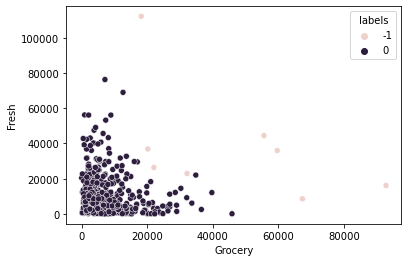

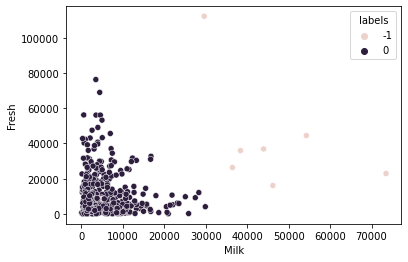

In [42]:
sns.scatterplot(expirement1_df.Grocery, expirement1_df.Fresh, hue=expirement1_df.labels)
plt.show()

sns.scatterplot(expirement1_df.Milk, expirement1_df.Fresh, hue=expirement1_df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

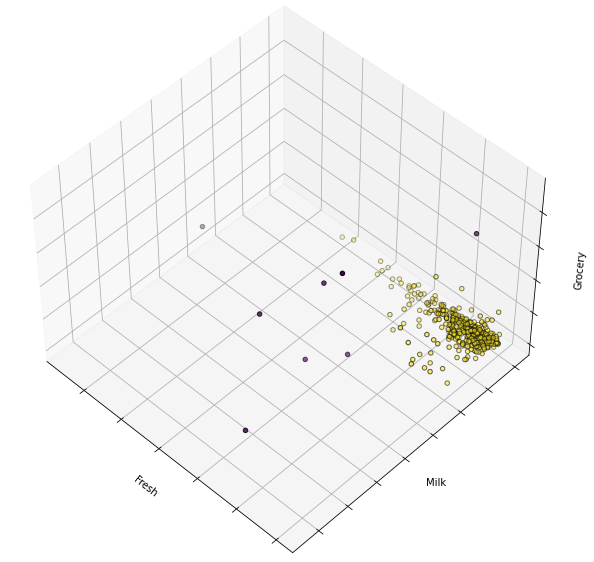

In [43]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(expirement1_df.Fresh, expirement1_df.Milk, expirement1_df.Grocery,
           c=expirement1_df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

## Experiment 2

### - Double the min_samples parameter. Run your model and visualize the results. Consider what changed and why.

In [44]:
# make dataframe for cluster
expirement2_df = df[["Grocery", "Milk","Fresh"]]

In [45]:
expirement2_df.head()

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057
2,7684,8808,6353
3,4221,1196,13265
4,7198,5410,22615


In [46]:
# convert to numpy array
np_array = expirement2_df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 7561.,  9656., 12669.],
       [ 9568.,  9810.,  7057.],
       [ 7684.,  8808.,  6353.],
       [ 4221.,  1196., 13265.],
       [ 7198.,  5410., 22615.],
       [ 5126.,  8259.,  9413.],
       [ 6975.,  3199., 12126.],
       [ 9426.,  4956.,  7579.],
       [ 6192.,  3648.,  5963.],
       [18881., 11093.,  6006.]], dtype=float32)

In [47]:
# scale to MinMax
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.08146416, 0.13072723, 0.11294005],
       [0.10309667, 0.13282411, 0.06289903],
       [0.08278991, 0.11918086, 0.05662161],
       [0.04546386, 0.01553586, 0.11825445],
       [0.07755155, 0.07291369, 0.20162643],
       [0.05521843, 0.11170568, 0.08390699],
       [0.07514793, 0.04280871, 0.10809823],
       [0.10156612, 0.06673203, 0.06755359],
       [0.06670834, 0.04892229, 0.05314406],
       [0.20347716, 0.15029342, 0.05352748]], dtype=float32)

In [48]:
# create model

## use double min_samples 
dbsc = DBSCAN(eps = .10, min_samples = 40).fit(np_array)

In [49]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(expirement2_df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [50]:
# Save a copy of the original dataframe
original_df = expirement2_df.copy()

In [51]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [52]:
# Merge the scaled and non-scaled values into one dataframe
expirement2_df = expirement2_df.merge(scaled_df, on=expirement2_df.index)
expirement2_df = expirement2_df.drop(columns=['key_0'])

In [53]:
expirement2_df.head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,7561,9656,12669,0.081464,0.130727,0.112940
1,9568,9810,7057,0.103097,0.132824,0.062899
2,7684,8808,6353,0.082790,0.119181,0.056622
3,4221,1196,13265,0.045464,0.015536,0.118254
4,7198,5410,22615,0.077552,0.072914,0.201626


In [54]:
# extract labels by making predictions
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
# assign labels to a column on df
expirement2_df['labels'] = labels
expirement2_df.labels.value_counts()

## 392 observations belong to cluster 0

## 48 obsverations are outliers that do not belong to any cluster
### according to this model

 0    392
-1     48
Name: labels, dtype: int64

In [56]:
# view outliers
expirement2_df[expirement2_df.labels==-1].head()

,Grocery,Milk,Fresh,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
12,11757,12319,31714,0.126691,0.166987,0.282760,-1
23,22019,36423,26373,0.237300,0.495187,0.235136,-1
28,25957,20484,4113,0.279746,0.278161,0.036648,-1
29,2609,2100,43088,0.028089,0.027845,0.384180,-1
39,902,555,56159,0.009690,0.006808,0.500731,-1


In [57]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(expirement2_df.describe())
print("-------------")
print("Inliers")
print(expirement2_df[expirement2_df.labels==0].describe())
print("-------------")
print("Outliers")
print(expirement2_df[expirement2_df.labels==-1].describe())

Population
            Grocery          Milk          Fresh  Scaled_Grocery  Scaled_Milk  \
count    440.000000    440.000000     440.000000      440.000000   440.000000   
mean    7951.277273   5796.265909   12000.297727        0.085671     0.078173   
std     9503.162829   7380.377175   12647.328865        0.102430     0.100491   
min        3.000000     55.000000       3.000000        0.000000     0.000000   
25%     2153.000000   1533.000000    3127.750000        0.023174     0.020124   
50%     4755.500000   3627.000000    8504.000000        0.051225     0.048636   
75%    10655.750000   7190.250000   16933.750000        0.114821     0.097154   
max    92780.000000  73498.000000  112151.000000        1.000000     1.000000   

       Scaled_Fresh      labels  
count    440.000000  440.000000  
mean       0.106977   -0.109091  
std        0.112774    0.312108  
min        0.000000   -1.000000  
25%        0.027863    0.000000  
50%        0.075802    0.000000  
75%        0.150968  

In [58]:
## outliers in this model appear to buy large amounts of grocery, milk, and fresh

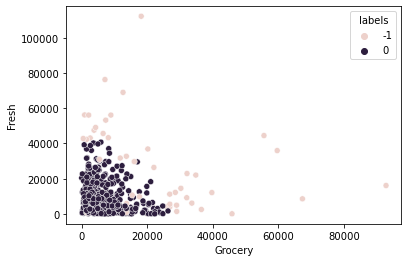

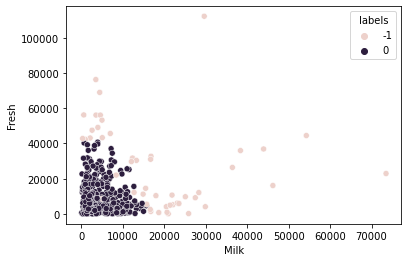

In [59]:
sns.scatterplot(expirement2_df.Grocery, expirement2_df.Fresh, hue=expirement2_df.labels)
plt.show()

sns.scatterplot(expirement2_df.Milk, expirement2_df.Fresh, hue=expirement2_df.labels)
plt.show()

Text(0.5, 0, 'Grocery')

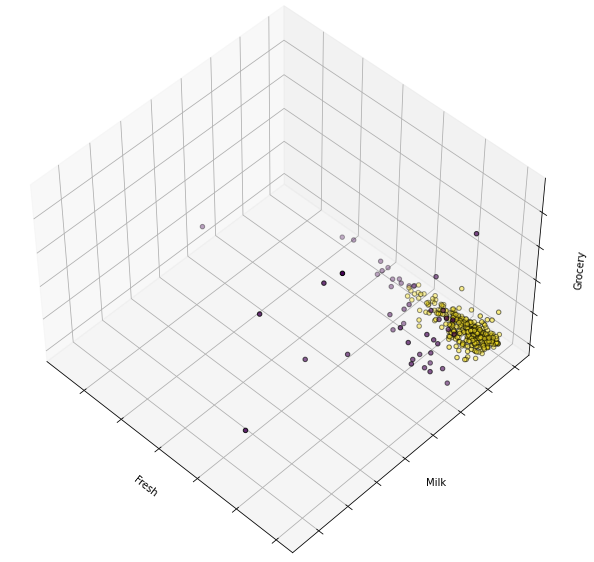

In [60]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(expirement2_df.Fresh, expirement2_df.Milk, expirement2_df.Grocery,
           c=expirement2_df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')

# Exercise

## 1. Use DBSCAN to detect anomalies in other products from the customers dataset.

In [61]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [62]:
exercise_df = df[["Delicassen", "Frozen","Fresh"]]

In [63]:
exercise_df.head()

,Delicassen,Frozen,Fresh
customer_id,,,
0,1338,214,12669
1,1776,1762,7057
2,7844,2405,6353
3,1788,6404,13265
4,5185,3915,22615


In [64]:
# convert to numpy array
np_array = exercise_df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 1338.,   214., 12669.],
       [ 1776.,  1762.,  7057.],
       [ 7844.,  2405.,  6353.],
       [ 1788.,  6404., 13265.],
       [ 5185.,  3915., 22615.],
       [ 1451.,   666.,  9413.],
       [  545.,   480., 12126.],
       [ 2566.,  1669.,  7579.],
       [  750.,   425.,  5963.],
       [ 2098.,  1159.,  6006.]], dtype=float32)

In [65]:
# scale to MinMax
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.02784731, 0.0031063 , 0.11294005],
       [0.03698373, 0.02854842, 0.06289903],
       [0.16355862, 0.03911643, 0.05662161],
       [0.03723405, 0.1048419 , 0.11825445],
       [0.10809346, 0.063934  , 0.20162643],
       [0.03020442, 0.01053514, 0.08390699],
       [0.0113058 , 0.00747814, 0.10809823],
       [0.05346267, 0.02701992, 0.06755359],
       [0.01558198, 0.00657419, 0.05314406],
       [0.04370046, 0.01863783, 0.05352748]], dtype=float32)

In [66]:
# create model

## use double min_samples 
dbsc = DBSCAN(eps = .20, min_samples = 20).fit(np_array)

In [67]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(exercise_df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [68]:
# Save a copy of the original dataframe
original_df = exercise_df.copy()

In [69]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [70]:
# Merge the scaled and non-scaled values into one dataframe
exercise_df = exercise_df.merge(scaled_df, on=exercise_df.index)
exercise_df = exercise_df.drop(columns=['key_0'])

In [71]:
exercise_df.head()

,Delicassen,Frozen,Fresh,Scaled_Delicassen,Scaled_Frozen,Scaled_Fresh
0,1338,214,12669,0.027847,0.003106,0.112940
1,1776,1762,7057,0.036984,0.028548,0.062899
2,7844,2405,6353,0.163559,0.039116,0.056622
3,1788,6404,13265,0.037234,0.104842,0.118254
4,5185,3915,22615,0.108093,0.063934,0.201626


In [72]:
# extract labels by making predictions
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
# assign labels to a column on df
exercise_df['labels'] = labels
exercise_df.labels.value_counts()

## 434 observations belong to cluster 0

## 6 obsverations are outliers that do not belong to any cluster
### according to this model

 0    434
-1      6
Name: labels, dtype: int64

In [74]:
# view outliers
exercise_df[exercise_df.labels==-1]

,Delicassen,Frozen,Fresh,Scaled_Delicassen,Scaled_Frozen,Scaled_Fresh,labels
23,16523,5154,26373,0.344597,0.084298,0.235136,-1
93,2698,35009,11314,0.056216,0.574979,0.100858,-1
125,918,16538,76237,0.019086,0.271399,0.679762,-1
181,8550,16745,112151,0.178285,0.274801,1.000000,-1
183,47943,36534,36847,1.000000,0.600043,0.328530,-1
325,5609,60869,32717,0.116938,1.000000,0.291704,-1


In [75]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(exercise_df.describe())
print("-------------")
print("Inliers")
print(exercise_df[exercise_df.labels==0].describe())
print("-------------")
print("Outliers")
print(exercise_df[exercise_df.labels==-1].describe())

Population
         Delicassen        Frozen          Fresh  Scaled_Delicassen  \
count    440.000000    440.000000     440.000000         440.000000   
mean    1524.870455   3071.931818   12000.297727           0.031745   
std     2820.105937   4854.673333   12647.328865           0.058826   
min        3.000000     25.000000       3.000000           0.000000   
25%      408.250000    742.250000    3127.750000           0.008453   
50%      965.500000   1526.000000    8504.000000           0.020077   
75%     1820.250000   3554.250000   16933.750000           0.037907   
max    47943.000000  60869.000000  112151.000000           1.000000   

       Scaled_Frozen  Scaled_Fresh      labels  
count     440.000000    440.000000  440.000000  
mean        0.050078      0.106977   -0.013636  
std         0.079789      0.112774    0.116108  
min         0.000000      0.000000   -1.000000  
25%         0.011788      0.027863    0.000000  
50%         0.024670      0.075802    0.000000  
75%   

In [76]:
## on this model outliers appear to buy larger quantities of delicassen, frozen, and fresh

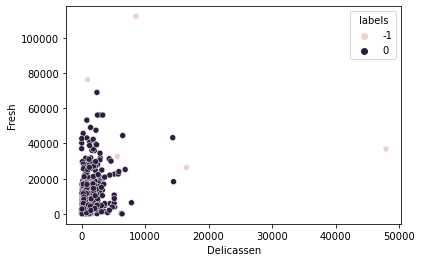

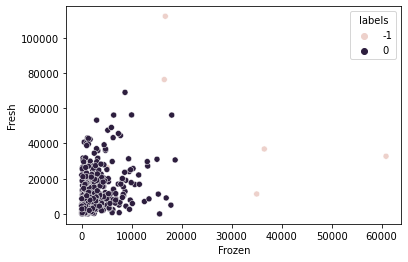

In [77]:
sns.scatterplot(exercise_df.Delicassen, exercise_df.Fresh, hue=exercise_df.labels)
plt.show()

sns.scatterplot(exercise_df.Frozen, exercise_df.Fresh, hue=exercise_df.labels)
plt.show()

Text(0.5, 0, 'Delicassen')

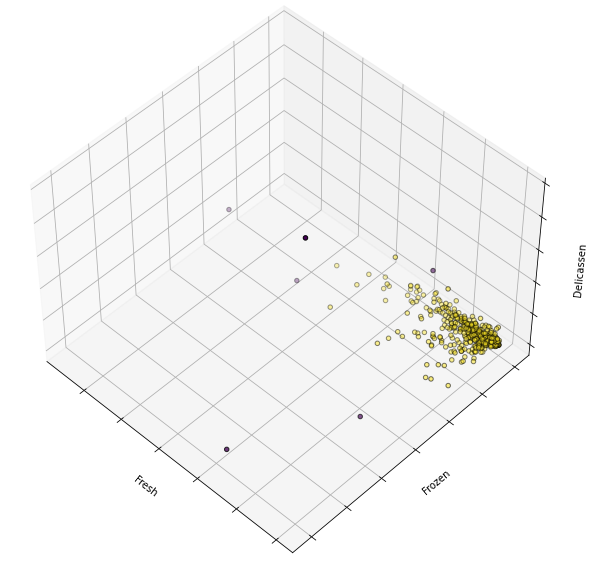

In [78]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(exercise_df.Fresh, exercise_df.Frozen, exercise_df.Delicassen,
           c=exercise_df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Delicassen')

## 2. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [79]:
df = pd.read_csv('zillowcluster_df.csv')

In [80]:
df.head()

,Unnamed: 0,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,0,NaN,NaN,2.0,NaN,NaN,NaN,10711855,1087254,NaN,...,NaN,6.037113e+13,-0.007357,2017-07-07,NaN,NaN,NaN,Central,NaN,NaN
1,1,NaN,NaN,2.0,NaN,NaN,1.0,10711877,1072280,NaN,...,NaN,6.037113e+13,0.021066,2017-08-29,Central,NaN,NaN,Central,NaN,NaN
2,2,NaN,NaN,2.0,NaN,NaN,1.0,10711888,1340933,NaN,...,NaN,6.037113e+13,0.077174,2017-04-04,Central,NaN,NaN,Central,NaN,NaN
3,3,NaN,NaN,2.0,NaN,NaN,NaN,10711910,1878109,NaN,...,NaN,6.037113e+13,-0.041238,2017-03-17,NaN,NaN,NaN,Central,NaN,NaN
4,4,NaN,NaN,2.0,NaN,NaN,NaN,10711923,2190858,NaN,...,NaN,6.037113e+13,-0.009496,2017-03-24,NaN,NaN,NaN,Central,NaN,NaN


In [81]:
list(df.columns)

['Unnamed: 0',
 'typeconstructiontypeid',
 'storytypeid',
 'heatingorsystemtypeid',
 'buildingclasstypeid',
 'architecturalstyletypeid',
 'airconditioningtypeid',
 'parcelid',
 'id',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'num

In [82]:
df = df[["bedroomcnt", "bathroomcnt","calculatedfinishedsquarefeet", "logerror"]]

In [83]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,logerror
0,3.0,2.0,2107.0,-0.007357
1,4.0,2.0,1882.0,0.021066
2,4.0,2.0,1882.0,0.077174
3,3.0,2.0,1477.0,-0.041238
4,4.0,2.0,1918.0,-0.009496


In [84]:
df = df.dropna()

# remove nulls for exercise

In [85]:
df.shape

(77184, 4)

In [86]:
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
logerror                        0
dtype: int64

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77184 entries, 0 to 77411
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    77184 non-null  float64
 1   bathroomcnt                   77184 non-null  float64
 2   calculatedfinishedsquarefeet  77184 non-null  float64
 3   logerror                      77184 non-null  float64
dtypes: float64(4)
memory usage: 2.9 MB


In [88]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,logerror
count,77184.000000,77184.000000,77184.000000,77184.000000
mean,3.060932,2.304700,1785.229465,0.016923
std,1.130559,0.991412,954.051796,0.168941
min,0.000000,0.000000,128.000000,-4.655420
25%,2.000000,2.000000,1182.000000,-0.024099
50%,3.000000,2.000000,1543.000000,0.006749
75%,4.000000,3.000000,2113.000000,0.039299
max,16.000000,18.000000,35640.000000,5.262999


In [89]:
# make values into numpy array

np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 3.0000000e+00,  2.0000000e+00,  2.1070000e+03, -7.3572891e-03],
       [ 4.0000000e+00,  2.0000000e+00,  1.8820000e+03,  2.1066284e-02],
       [ 4.0000000e+00,  2.0000000e+00,  1.8820000e+03,  7.7174455e-02],
       [ 3.0000000e+00,  2.0000000e+00,  1.4770000e+03, -4.1237637e-02],
       [ 4.0000000e+00,  2.0000000e+00,  1.9180000e+03, -9.4964216e-03],
       [ 3.0000000e+00,  2.0000000e+00,  2.0310000e+03,  1.2707557e-03],
       [ 3.0000000e+00,  3.0000000e+00,  1.6780000e+03,  2.3298189e-02],
       [ 4.0000000e+00,  2.0000000e+00,  1.8820000e+03,  4.1138045e-02],
       [ 3.0000000e+00,  2.0000000e+00,  1.7090000e+03,  1.2091854e-02],
       [ 3.0000000e+00,  2.0000000e+00,  1.6390000e+03,  4.6516660e-01]],
      dtype=float32)

In [90]:
# scale numpy array to MinMax

scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.1875    , 0.11111111, 0.05572764, 0.46862945],
       [0.25      , 0.11111111, 0.04939175, 0.47149518],
       [0.25      , 0.11111111, 0.04939175, 0.47715214],
       [0.1875    , 0.11111111, 0.03798716, 0.46521354],
       [0.25      , 0.11111111, 0.05040549, 0.46841377],
       [0.1875    , 0.11111111, 0.05358752, 0.46949935],
       [0.1875    , 0.16666667, 0.04364721, 0.47172022],
       [0.25      , 0.11111111, 0.04939175, 0.47351888],
       [0.1875    , 0.11111111, 0.04452016, 0.47059035],
       [0.1875    , 0.11111111, 0.042549  , 0.5162705 ]], dtype=float32)

In [91]:
# make predictive model

dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [92]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

In [93]:
# Save a copy of the original dataframe
original_df = df.copy()

In [94]:
# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

In [95]:
# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [96]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,logerror,Scaled_bedroomcnt,Scaled_bathroomcnt,Scaled_calculatedfinishedsquarefeet,Scaled_logerror
0,3.0,2.0,2107.0,-0.007357,0.1875,0.111111,0.055728,0.468629
1,4.0,2.0,1882.0,0.021066,0.2500,0.111111,0.049392,0.471495
2,4.0,2.0,1882.0,0.077174,0.2500,0.111111,0.049392,0.477152
3,3.0,2.0,1477.0,-0.041238,0.1875,0.111111,0.037987,0.465214
4,4.0,2.0,1918.0,-0.009496,0.2500,0.111111,0.050405,0.468414


In [97]:
# extract labels for outliers

labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [98]:
df['labels'] = labels
df.labels.value_counts()

## 77148 observations belong to cluster 0

## 36 obsverations are outliers that do not belong to any cluster
### according to this model

 0    77148
-1       36
Name: labels, dtype: int64

In [99]:
df[df.labels==-1].head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,logerror,Scaled_bedroomcnt,Scaled_bathroomcnt,Scaled_calculatedfinishedsquarefeet,Scaled_logerror,labels
277,2.0,3.0,2000.0,-3.737018,0.1250,0.166667,0.052715,0.092596,-1
654,6.0,6.0,5256.0,-1.702338,0.3750,0.333333,0.144402,0.297737,-1
668,7.0,9.0,14829.0,-0.313389,0.4375,0.500000,0.413973,0.437775,-1
834,0.0,0.0,18197.0,-0.483428,0.0000,0.000000,0.508814,0.420631,-1
3713,5.0,4.0,12616.0,0.195830,0.3125,0.222222,0.351656,0.489115,-1


In [100]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
         bedroomcnt   bathroomcnt  calculatedfinishedsquarefeet      logerror  \
count  77184.000000  77184.000000                  77184.000000  77184.000000   
mean       3.060932      2.304700                   1785.229465      0.016923   
std        1.130559      0.991412                    954.051796      0.168941   
min        0.000000      0.000000                    128.000000     -4.655420   
25%        2.000000      2.000000                   1182.000000     -0.024099   
50%        3.000000      2.000000                   1543.000000      0.006749   
75%        4.000000      3.000000                   2113.000000      0.039299   
max       16.000000     18.000000                  35640.000000      5.262999   

       Scaled_bedroomcnt  Scaled_bathroomcnt  \
count       77184.000000        77184.000000   
mean            0.191308            0.128075   
std             0.070646            0.055094   
min             0.000000            0.000000   
25%             0.1

In [101]:
## outliers in this model appear to be homes with many bedrooms and bathrooms, and much larger square ft

## also higher positive logerror

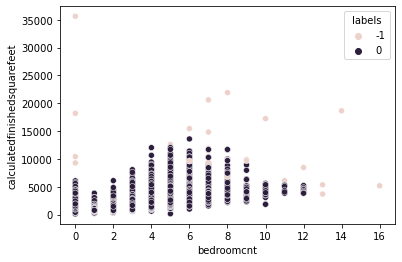

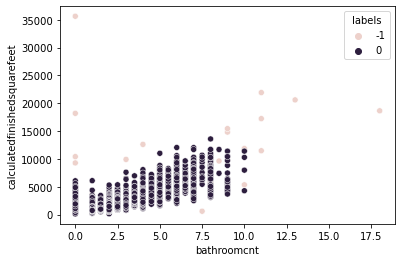

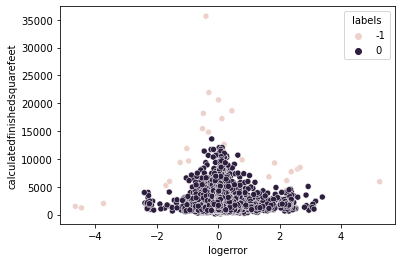

In [102]:
sns.scatterplot(df.bedroomcnt, df.calculatedfinishedsquarefeet, hue=df.labels)
plt.show()

sns.scatterplot(df.bathroomcnt, df.calculatedfinishedsquarefeet, hue=df.labels)
plt.show()

sns.scatterplot(df.logerror, df.calculatedfinishedsquarefeet, hue=df.labels)
plt.show()

Text(0.5, 0, 'logerror')

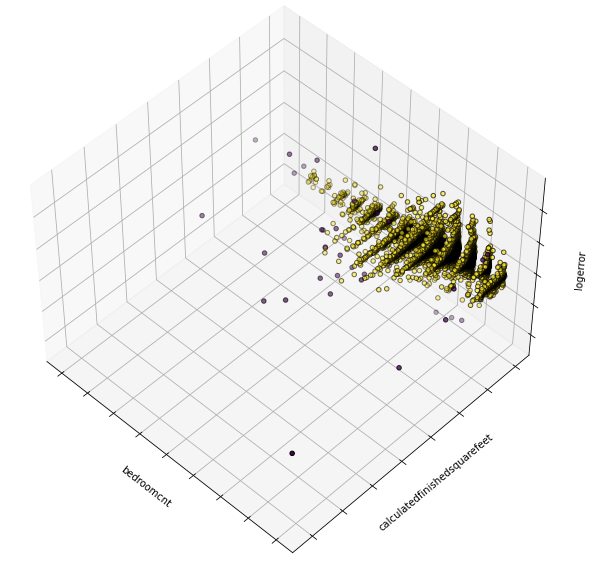

In [103]:
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.bedroomcnt, df.calculatedfinishedsquarefeet, df.logerror,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('bedroomcnt')
ax.set_ylabel('calculatedfinishedsquarefeet')
ax.set_zlabel('logerror')

## Curriculum Logs Data

In [112]:
url = get_db_url("curriculum_logs")

sql = """
select *
from logs
join cohorts on logs.cohort_id = cohorts.id;
"""

df = pd.read_sql(sql, url)

In [113]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2


In [114]:
df.index = pd.to_datetime(df.date + " " + df.time)

df = df.drop(columns=['created_at', 'updated_at', 'deleted_at'], axis=1)

df = df.dropna()

In [115]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,program_id
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,1
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2


In [116]:
df.shape

(847329, 12)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847329 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        847329 non-null  object 
 1   time        847329 non-null  object 
 2   path        847329 non-null  object 
 3   user_id     847329 non-null  int64  
 4   cohort_id   847329 non-null  float64
 5   ip          847329 non-null  object 
 6   id          847329 non-null  int64  
 7   name        847329 non-null  object 
 8   slack       847329 non-null  object 
 9   start_date  847329 non-null  object 
 10  end_date    847329 non-null  object 
 11  program_id  847329 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 84.0+ MB


In [118]:
df.describe()

,user_id,cohort_id,id,program_id
count,847329.000000,847329.000000,847329.000000,847329.000000
mean,456.707192,48.501042,48.501042,2.086003
std,250.734309,32.795501,32.795501,0.388230
min,1.000000,1.000000,1.000000,1.000000
25%,263.000000,28.000000,28.000000,2.000000
50%,476.000000,33.000000,33.000000,2.000000
75%,648.000000,57.000000,57.000000,2.000000
max,981.000000,139.000000,139.000000,4.000000


In [119]:
df.isnull().sum()

date          0
time          0
path          0
user_id       0
cohort_id     0
ip            0
id            0
name          0
slack         0
start_date    0
end_date      0
program_id    0
dtype: int64

In [128]:
df.groupby('user_id').count()

,date,time,path,cohort_id,ip,id,name,slack,start_date,end_date,program_id
user_id,,,,,,,,,,,
1,7404,7404,7404,7404,7404,7404,7404,7404,7404,7404,7404
2,1541,1541,1541,1541,1541,1541,1541,1541,1541,1541,1541
3,1562,1562,1562,1562,1562,1562,1562,1562,1562,1562,1562
4,692,692,692,692,692,692,692,692,692,692,692
5,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701
...,...,...,...,...,...,...,...,...,...,...,...
977,86,86,86,86,86,86,86,86,86,86,86
978,55,55,55,55,55,55,55,55,55,55,55
979,127,127,127,127,127,127,127,127,127,127,127
